In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
import string
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import math

In [3]:
en_filename = "/kaggle/input/data-nlp/train.en.txt"
vi_filename = "/kaggle/input/data-nlp/train.vi.txt"

raw_en_lines = open(en_filename, encoding='utf-8').read().strip().split("\n")
raw_vi_lines = open(vi_filename, encoding='utf-8').read().strip().split("\n")

In [4]:
import re
import unicodedata

def preprocess(sentence):
    # Chuẩn hóa unicode (rất quan trọng với tiếng Việt)
    sentence = unicodedata.normalize("NFC", sentence)

    # Xóa khoảng trắng đầu/cuối và rút gọn khoảng trắng giữa
    sentence = sentence.strip()
    sentence = re.sub(r"\s+", " ", sentence)

    return sentence


In [5]:
# Apply preprocess to both EN and VI lines
en_lines = [preprocess(line) for line in raw_en_lines]
vi_lines = [preprocess(line) for line in raw_vi_lines]

In [6]:
# Optional: filter sentences too long
filtered_en = []
filtered_vi = []
for e, v in zip(en_lines, vi_lines):
    if 5 <= len(e.split()) <= 128 and 5 <= len(v.split()) <= 128:
        filtered_en.append(e)
        filtered_vi.append(v)
en_lines, vi_lines = filtered_en, filtered_vi
print(f"Số lượng câu còn lại sau lọc: {len(en_lines)} cặp câu song ngữ")

Số lượng câu còn lại sau lọc: 129787 cặp câu song ngữ


In [7]:
# Ghi toàn bộ corpus vào 1 file text
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in raw_en_lines + raw_vi_lines:
        f.write(line.strip() + "\n")


In [8]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input='/kaggle/working/corpus.txt',
    model_prefix='bpe_model',
    vocab_size=8000,          # số lượng token BPE
    model_type='bpe',         # dùng BPE, không dùng unigram
    character_coverage=1.0,   # 1.0 = cover toàn bộ ký tự
    bos_id=1, eos_id=2, pad_id=0, unk_id=3
)
print("success")


success


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/working/corpus.txt
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  

In [9]:
sp = spm.SentencePieceProcessor()
sp.load('/kaggle/working/bpe_model.model')


True

In [10]:
class Language:
    def __init__(self, lines, sp_processor):
        self.lines = lines
        self.sp = sp_processor  # SentencePiece model
        self.word2id = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.id2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.vocab_size = 0
        self.max_len = 0
        self.min_len = float('inf')
        self.init_language_params()

    def init_language_params(self):
        vocab = set()
        for line in self.lines:
            tokens = self.sp.encode(line, out_type=str)
            vocab.update(tokens)
        for idx, word in enumerate(vocab, start=3):
            self.word2id[word] = idx
            self.id2word[idx] = word
        self.vocab_size = len(self.word2id)
        self.max_len = max(len(self.sp.encode(line, out_type=str)) for line in self.lines) + 2  # +2 for <SOS> and <EOS>
        self.min_len = min(len(self.sp.encode(line, out_type=str)) for line in self.lines) + 2

    def sentence_to_vector(self, sentence):
        tokens = ["<SOS>"] + self.sp.encode(sentence, out_type=str) + ["<EOS>"]
        return [self.word2id.get(token, 3) for token in tokens]  # 3 là <UNK>

    def vector_to_sentence(self, vector):
        tokens = [self.id2word.get(id, "<UNK>") for id in vector if id not in [0, 1, 2]]
        return " ".join(tokens)


In [11]:
inp_lang = Language(en_lines,sp)
tar_lang = Language(vi_lines,sp)
print(inp_lang.max_len, inp_lang.min_len)
print(tar_lang.max_len, tar_lang.min_len)

inp_vector = [inp_lang.sentence_to_vector(line) for line in inp_lang.lines]
tar_vector = [tar_lang.sentence_to_vector(line) for line in tar_lang.lines]

def pad_sequences(sequences, WWmax_len):
    return [seq + [0] * (WWmax_len - len(seq)) if len(seq) < WWmax_len else seq[:WWmax_len] for seq in sequences]

inp_tensor = pad_sequences(inp_vector, inp_lang.max_len)
tar_tensor = pad_sequences(tar_vector, tar_lang.max_len)
inp_tensor = torch.tensor(inp_tensor, dtype=torch.long)
tar_tensor = torch.tensor(tar_tensor, dtype=torch.long)
print(f"Input tensor shape: {inp_tensor.shape}, Target tensor shape: {tar_tensor.shape}")

187 7
165 7
Input tensor shape: torch.Size([129787, 187]), Target tensor shape: torch.Size([129787, 165])


In [12]:
# x_train, x_val, y_train, y_val = train_test_split(inp_tensor, tar_tensor, test_size=0.1, random_state=42)

# Chia dữ liệu:
# Bước 1: Chia ra train_val và test trước:
x_train_val, x_test, y_train_val, y_test = train_test_split(inp_tensor, tar_tensor, test_size = 0.1, random_state = 42)
# Bước 2: Chia tran_vail thành train và val
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.111, random_state = 42)

In [13]:
print(f"Train set size: {x_train.shape[0]} samples")
print(f"Validation set size: {x_val.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")

Train set size: 103842 samples
Validation set size: 12966 samples
Test set size: 12979 samples


In [14]:
class TranslationDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

BATCH_SIZE = 32
train_dataset = TranslationDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TranslationDataset(x_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=1024, dropout=0.1,max_len = 512 ):
        super(TransformerModel, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = self.create_positional_encoding(max_len=max_len, d_model=d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True

        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

    def create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        src = self.src_embedding(src) * math.sqrt(self.d_model) + self.positional_encoding[:, :src.size(1), :].to(src.device)
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model) + self.positional_encoding[:, :tgt.size(1), :].to(tgt.device)
        output = self.transformer(
            src, tgt,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask
        )
        return self.fc(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

In [16]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_len = max(inp_lang.max_len, tar_lang.max_len)
print(max_len)

model = TransformerModel(
    src_vocab_size=inp_lang.vocab_size,
    tgt_vocab_size=tar_lang.vocab_size,
    d_model=256,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=1024,
    max_len=max_len   # THÊM VÀO ĐÂY
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore <PAD>
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

187


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

EPOCHS = 30
best_val_loss = float("inf")
patience = 3
counter = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for src, tgt in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        src_padding_mask = (src == 0).to(device)
        tgt_padding_mask = (tgt_input == 0).to(device)

        with autocast():
            output = model(
                src, tgt_input,
                tgt_mask=tgt_mask,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask
            )
            loss = criterion(output.reshape(-1, tar_lang.vocab_size), tgt_output.reshape(-1))

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Tiến hành tiếp hàm đánh giá cho {epoch+1}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for src, tgt in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_mask = model.generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            src_padding_mask = (src == 0).to(device)
            tgt_padding_mask = (tgt_input == 0).to(device)

            with autocast():
                output = model(
                    src, tgt_input,
                    tgt_mask=tgt_mask,
                    src_padding_mask=src_padding_mask,
                    tgt_padding_mask=tgt_padding_mask
                )
                loss = criterion(output.reshape(-1, tar_lang.vocab_size), tgt_output.reshape(-1))
                total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_transformer_noPre_model.pth")
        print(f" Model saved at epoch {epoch+1} with val_loss: {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"No improvement in Val Loss for {counter} epoch(s)")

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


/tmp/ipykernel_31/1933765229.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1:   0%|          | 0/3246 [00:00<?, ?it/s]/tmp/ipykernel_31/1933765229.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Training Epoch 1: 100%|██████████| 3246/3246 [05:39<00:00,  9.57it/s]


Tiến hành tiếp hàm đánh giá cho 1


Validation Epoch 1:   0%|          | 0/406 [00:00<?, ?it/s]/tmp/ipykernel_31/1933765229.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation Epoch 1: 100%|██████████| 406/406 [00:14<00:00, 27.97it/s]


Epoch 1/30, Train Loss: 5.1351, Val Loss: 4.4517
 Model saved at epoch 1 with val_loss: 4.4517


Training Epoch 2: 100%|██████████| 3246/3246 [05:51<00:00,  9.23it/s]


Tiến hành tiếp hàm đánh giá cho 2


Validation Epoch 2: 100%|██████████| 406/406 [00:14<00:00, 27.84it/s]


Epoch 2/30, Train Loss: 4.2914, Val Loss: 4.0591
 Model saved at epoch 2 with val_loss: 4.0591


Training Epoch 3: 100%|██████████| 3246/3246 [05:52<00:00,  9.21it/s]


Tiến hành tiếp hàm đánh giá cho 3


Validation Epoch 3: 100%|██████████| 406/406 [00:14<00:00, 27.95it/s]


Epoch 3/30, Train Loss: 3.9747, Val Loss: 3.8166
 Model saved at epoch 3 with val_loss: 3.8166


Training Epoch 4: 100%|██████████| 3246/3246 [05:52<00:00,  9.21it/s]


Tiến hành tiếp hàm đánh giá cho 4


Validation Epoch 4: 100%|██████████| 406/406 [00:14<00:00, 27.95it/s]


Epoch 4/30, Train Loss: 3.7547, Val Loss: 3.6314
 Model saved at epoch 4 with val_loss: 3.6314


Training Epoch 5: 100%|██████████| 3246/3246 [05:51<00:00,  9.23it/s]


Tiến hành tiếp hàm đánh giá cho 5


Validation Epoch 5: 100%|██████████| 406/406 [00:14<00:00, 27.94it/s]


Epoch 5/30, Train Loss: 3.5820, Val Loss: 3.5003
 Model saved at epoch 5 with val_loss: 3.5003


Training Epoch 6: 100%|██████████| 3246/3246 [05:51<00:00,  9.23it/s]


Tiến hành tiếp hàm đánh giá cho 6


Validation Epoch 6: 100%|██████████| 406/406 [00:14<00:00, 27.94it/s]


Epoch 6/30, Train Loss: 3.4380, Val Loss: 3.3800
 Model saved at epoch 6 with val_loss: 3.3800


Training Epoch 7: 100%|██████████| 3246/3246 [05:51<00:00,  9.23it/s]


Tiến hành tiếp hàm đánh giá cho 7


Validation Epoch 7: 100%|██████████| 406/406 [00:14<00:00, 27.95it/s]


Epoch 7/30, Train Loss: 3.3101, Val Loss: 3.2811
 Model saved at epoch 7 with val_loss: 3.2811


Training Epoch 8: 100%|██████████| 3246/3246 [05:51<00:00,  9.24it/s]


Tiến hành tiếp hàm đánh giá cho 8


Validation Epoch 8: 100%|██████████| 406/406 [00:14<00:00, 27.97it/s]


Epoch 8/30, Train Loss: 3.1910, Val Loss: 3.1874
 Model saved at epoch 8 with val_loss: 3.1874


Training Epoch 9: 100%|██████████| 3246/3246 [05:51<00:00,  9.24it/s]


Tiến hành tiếp hàm đánh giá cho 9


Validation Epoch 9: 100%|██████████| 406/406 [00:14<00:00, 27.96it/s]


Epoch 9/30, Train Loss: 3.0803, Val Loss: 3.0833
 Model saved at epoch 9 with val_loss: 3.0833


Training Epoch 10: 100%|██████████| 3246/3246 [05:51<00:00,  9.24it/s]


Tiến hành tiếp hàm đánh giá cho 10


Validation Epoch 10: 100%|██████████| 406/406 [00:14<00:00, 28.00it/s]


Epoch 10/30, Train Loss: 2.9819, Val Loss: 3.0184
 Model saved at epoch 10 with val_loss: 3.0184


Training Epoch 11: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 11


Validation Epoch 11: 100%|██████████| 406/406 [00:14<00:00, 27.98it/s]


Epoch 11/30, Train Loss: 2.8931, Val Loss: 2.9508
 Model saved at epoch 11 with val_loss: 2.9508


Training Epoch 12: 100%|██████████| 3246/3246 [05:52<00:00,  9.21it/s]


Tiến hành tiếp hàm đánh giá cho 12


Validation Epoch 12: 100%|██████████| 406/406 [00:14<00:00, 27.85it/s]


Epoch 12/30, Train Loss: 2.8151, Val Loss: 2.8950
 Model saved at epoch 12 with val_loss: 2.8950


Training Epoch 13: 100%|██████████| 3246/3246 [05:51<00:00,  9.22it/s]


Tiến hành tiếp hàm đánh giá cho 13


Validation Epoch 13: 100%|██████████| 406/406 [00:14<00:00, 28.02it/s]


Epoch 13/30, Train Loss: 2.7415, Val Loss: 2.8444
 Model saved at epoch 13 with val_loss: 2.8444


Training Epoch 14: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 14


Validation Epoch 14: 100%|██████████| 406/406 [00:14<00:00, 27.93it/s]


Epoch 14/30, Train Loss: 2.6741, Val Loss: 2.8112
 Model saved at epoch 14 with val_loss: 2.8112


Training Epoch 15: 100%|██████████| 3246/3246 [05:52<00:00,  9.21it/s]


Tiến hành tiếp hàm đánh giá cho 15


Validation Epoch 15: 100%|██████████| 406/406 [00:14<00:00, 27.95it/s]


Epoch 15/30, Train Loss: 2.6135, Val Loss: 2.7705
 Model saved at epoch 15 with val_loss: 2.7705


Training Epoch 16: 100%|██████████| 3246/3246 [05:51<00:00,  9.24it/s]


Tiến hành tiếp hàm đánh giá cho 16


Validation Epoch 16: 100%|██████████| 406/406 [00:14<00:00, 28.02it/s]


Epoch 16/30, Train Loss: 2.5567, Val Loss: 2.7487
 Model saved at epoch 16 with val_loss: 2.7487


Training Epoch 17: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 17


Validation Epoch 17: 100%|██████████| 406/406 [00:14<00:00, 28.02it/s]


Epoch 17/30, Train Loss: 2.5050, Val Loss: 2.7100
 Model saved at epoch 17 with val_loss: 2.7100


Training Epoch 18: 100%|██████████| 3246/3246 [05:50<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 18


Validation Epoch 18: 100%|██████████| 406/406 [00:14<00:00, 27.99it/s]


Epoch 18/30, Train Loss: 2.4566, Val Loss: 2.6936
 Model saved at epoch 18 with val_loss: 2.6936


Training Epoch 19: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 19


Validation Epoch 19: 100%|██████████| 406/406 [00:14<00:00, 28.00it/s]


Epoch 19/30, Train Loss: 2.4115, Val Loss: 2.6681
 Model saved at epoch 19 with val_loss: 2.6681


Training Epoch 20: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 20


Validation Epoch 20: 100%|██████████| 406/406 [00:14<00:00, 27.98it/s]


Epoch 20/30, Train Loss: 2.3686, Val Loss: 2.6570
 Model saved at epoch 20 with val_loss: 2.6570


Training Epoch 21: 100%|██████████| 3246/3246 [05:51<00:00,  9.24it/s]


Tiến hành tiếp hàm đánh giá cho 21


Validation Epoch 21: 100%|██████████| 406/406 [00:14<00:00, 28.00it/s]


Epoch 21/30, Train Loss: 2.3285, Val Loss: 2.6284
 Model saved at epoch 21 with val_loss: 2.6284


Training Epoch 22: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 22


Validation Epoch 22: 100%|██████████| 406/406 [00:14<00:00, 28.02it/s]


Epoch 22/30, Train Loss: 2.2911, Val Loss: 2.6173
 Model saved at epoch 22 with val_loss: 2.6173


Training Epoch 23: 100%|██████████| 3246/3246 [05:50<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 23


Validation Epoch 23: 100%|██████████| 406/406 [00:14<00:00, 28.00it/s]


Epoch 23/30, Train Loss: 2.2564, Val Loss: 2.5970
 Model saved at epoch 23 with val_loss: 2.5970


Training Epoch 26: 100%|██████████| 3246/3246 [05:50<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 26


Validation Epoch 26: 100%|██████████| 406/406 [00:14<00:00, 28.01it/s]


Epoch 26/30, Train Loss: 2.1595, Val Loss: 2.5674
 Model saved at epoch 26 with val_loss: 2.5674


Training Epoch 27: 100%|██████████| 3246/3246 [05:50<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 27


Validation Epoch 27: 100%|██████████| 406/406 [00:14<00:00, 27.98it/s]


Epoch 27/30, Train Loss: 2.1317, Val Loss: 2.5599
 Model saved at epoch 27 with val_loss: 2.5599


Training Epoch 28: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 28


Validation Epoch 28: 100%|██████████| 406/406 [00:14<00:00, 27.99it/s]


Epoch 28/30, Train Loss: 2.1028, Val Loss: 2.5518
 Model saved at epoch 28 with val_loss: 2.5518


Training Epoch 29: 100%|██████████| 3246/3246 [05:51<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 29


Validation Epoch 29: 100%|██████████| 406/406 [00:14<00:00, 27.98it/s]


Epoch 29/30, Train Loss: 2.0778, Val Loss: 2.5547
No improvement in Val Loss for 1 epoch(s)


Training Epoch 30: 100%|██████████| 3246/3246 [05:50<00:00,  9.25it/s]


Tiến hành tiếp hàm đánh giá cho 30


Validation Epoch 30: 100%|██████████| 406/406 [00:14<00:00, 28.07it/s]


Epoch 30/30, Train Loss: 2.0523, Val Loss: 2.5432
 Model saved at epoch 30 with val_loss: 2.5432


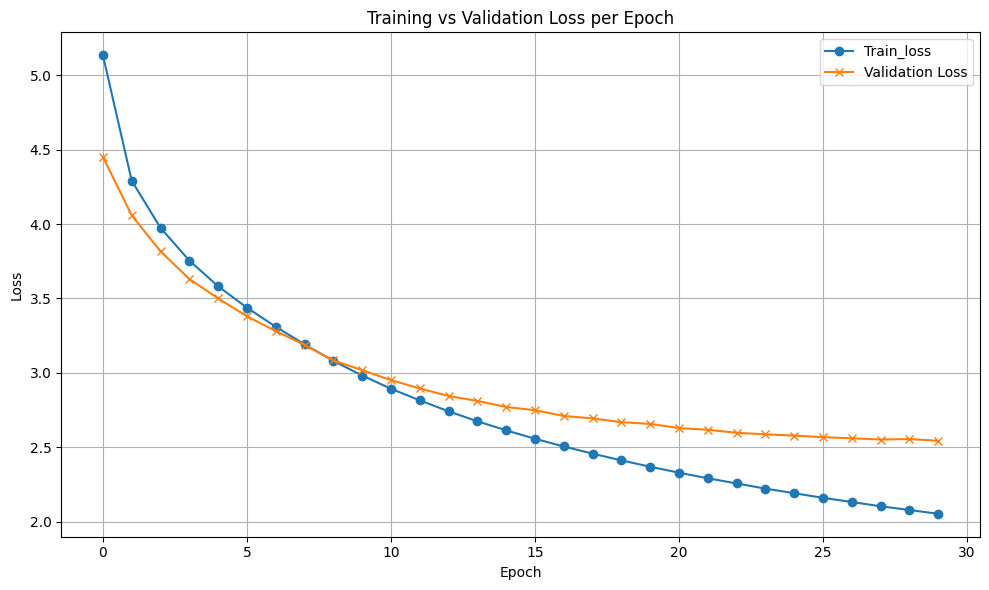

In [18]:
#Vẽ Biểu đồ:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_losses, label ='Train_loss', marker = 'o')
plt.plot(val_losses, label = 'Validation Loss', marker = 'x')
plt.title("Training vs Validation Loss per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
model.load_state_dict(torch.load('/kaggle/working/best_transformer_noPre_model.pth'))
# model.eval()  # Chuyển sang chế độ evaluation


/tmp/ipykernel_31/1450271491.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_transformer_noPre_model.pth'))


<All keys matched successfully>

In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

# Giới hạn số câu đánh giá
max_sentences = len(x_test)
num_samples = min(max_sentences, len(x_test))

smoothie = SmoothingFunction().method4
bleu_scores = []

model.eval()
with torch.no_grad():
    for idx in tqdm(range(num_samples), desc="Calculating BLEU on Test Set"):
        src = x_test[idx:idx+1].to(device)
        tgt = y_test[idx].cpu().numpy()

        tgt_infer = torch.tensor([[tar_lang.word2id["<SOS>"]]], dtype=torch.long, device=device)
        result = []

        for _ in range(tar_lang.max_len):
            tgt_mask = model.generate_square_subsequent_mask(tgt_infer.size(1)).to(device)
            src_padding_mask = (src == 0).to(device)
            tgt_padding_mask = (tgt_infer == 0).to(device)

            output = model(
                src, tgt_infer,
                tgt_mask=tgt_mask,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask
            )

            predicted_id = torch.argmax(output[:, -1, :], dim=-1).item()
            if predicted_id == tar_lang.word2id["<EOS>"]:
                break
            result.append(predicted_id)
            tgt_infer = torch.cat([tgt_infer, torch.tensor([[predicted_id]], device=device)], dim=1)

        ref_sentence = [tar_lang.vector_to_sentence(tgt).split()]
        pred_sentence = tar_lang.vector_to_sentence(result).split()

        score = sentence_bleu(ref_sentence, pred_sentence, smoothing_function=smoothie)
        bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU score on {num_samples} test sentences: {average_bleu*100:.4f}")


Calculating BLEU on Test Set: 100%|██████████| 12979/12979 [1:04:46<00:00,  3.34it/s]

Average BLEU score on 12979 test sentences: 17.8661


In [30]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=56441f90028b159b3713e35a8581484ad58fe425137d0bcd48f87436e2fdd556
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [31]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Giới hạn số câu đánh giá
max_sentences = 200
num_samples = min(max_sentences, len(x_test))

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge1_scores = []
rougeL_scores = []

model.eval()
with torch.no_grad():
    for idx in tqdm(range(num_samples), desc="Calculating ROUGE on Test Set"):
        src = x_test[idx:idx+1].to(device)
        tgt = y_test[idx].cpu().numpy()

        tgt_infer = torch.tensor([[tar_lang.word2id["<SOS>"]]], dtype=torch.long, device=device)
        result = []

        for _ in range(tar_lang.max_len):
            tgt_mask = model.generate_square_subsequent_mask(tgt_infer.size(1)).to(device)
            src_padding_mask = (src == 0).to(device)
            tgt_padding_mask = (tgt_infer == 0).to(device)

            output = model(
                src, tgt_infer,
                tgt_mask=tgt_mask,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask
            )

            predicted_id = torch.argmax(output[:, -1, :], dim=-1).item()
            if predicted_id == tar_lang.word2id["<EOS>"]:
                break
            result.append(predicted_id)
            tgt_infer = torch.cat([tgt_infer, torch.tensor([[predicted_id]], device=device)], dim=1)

        ref_sentence = tar_lang.vector_to_sentence(tgt)
        pred_sentence = tar_lang.vector_to_sentence(result)

        scores = scorer.score(ref_sentence, pred_sentence)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print(f"Average ROUGE-1 score on {num_samples} test sentences: {average_rouge1:.4f}")
print(f"Average ROUGE-L score on {num_samples} test sentences: {average_rougeL:.4f}")


Calculating ROUGE on Test Set: 100%|██████████| 200/200 [01:07<00:00,  2.94it/s]

Average ROUGE-1 score on 200 test sentences: 0.6367
Average ROUGE-L score on 200 test sentences: 0.5116


In [20]:
def translate(sentence_idx):
    model.eval()
    src = x_test[sentence_idx:sentence_idx+1].to(device)
    print(f"Input: {inp_lang.vector_to_sentence(src[0].cpu().numpy())}")

    with torch.no_grad():
        # Initialize target with <SOS>
        tgt = torch.tensor([[tar_lang.word2id["<SOS>"]]], dtype=torch.long, device=device)
        result = []

        for _ in range(tar_lang.max_len):
            tgt_mask = model.generate_square_subsequent_mask(tgt.size(1)).to(device)
            src_padding_mask = (src == 0).to(device)
            tgt_padding_mask = (tgt == 0).to(device)

            output = model(
                src, tgt,
                tgt_mask=tgt_mask,
                src_padding_mask=src_padding_mask,
                tgt_padding_mask=tgt_padding_mask
            )
            predicted_id = torch.argmax(output[:, -1, :], dim=-1).item()
            if predicted_id == tar_lang.word2id["<EOS>"]:
                break
            result.append(tar_lang.id2word[predicted_id])
            tgt = torch.cat([tgt, torch.tensor([[predicted_id]], device=device)], dim=1)

    return " ".join(result)

In [21]:
def decode_bpe(tokens):
    text = ''.join(tokens)       # Ghép lại
    text = text.replace('▁', ' ') # Nếu dùng SentencePiece thì dấu '▁' là khoảng trắng
    text = text.replace('_', ' ') # Nếu gạch dưới thì thay bằng khoảng trắng
    return text.strip()


In [22]:
for i in range(20):
    print(f"Test Translation {i}: {translate(i)}")
    print("-----------------")


Input: ▁And ▁because ▁of ▁those ▁four ▁character istics ▁they ▁are ▁able ▁to ▁fil ter ▁it ▁as ▁it ▁comes ▁into ▁the ▁country ▁.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Test Translation 0: ▁Và ▁bởi ▁vì ▁4 ▁loại ▁độc ▁tố ▁đó ▁có ▁thể ▁phân ▁biệt ▁được ▁nó ▁như ▁là ▁đất ▁nước ▁.
-----------------
Input: ▁And ▁so ▁there ▁are ▁some ▁psych ological ▁effects ▁that ▁happen ▁with ▁this ▁.
Test Translation 1: ▁Và ▁có ▁một ▁vài ▁tác ▁nhân ▁tâm ▁lý ▁mà ▁điều ▁này ▁xảy ▁ra ▁với ▁nó ▁.
-----------------
Input: ▁So ▁you ▁can ▁see ▁that ▁the ▁way ▁in ▁which ▁power ▁has ▁been ▁construct ed ▁in ▁China ▁is ▁very ▁different ▁from ▁our ▁experience ▁in ▁Western ▁history ▁.
Test Translation 2: ▁Bạn ▁có ▁thể ▁thấy ▁rằng ▁sức ▁mạnh ▁mà ▁quyền ▁lực ▁đã ▁được ▁xây ▁dựng ▁theo ▁cách ▁mà ▁Trung ▁Quốc ▁đã ▁được ▁xây ▁dựng ▁từ ▁lịch ▁sử ▁phương ▁Tây ▁.
-----------------
Input: ▁And ▁my ▁dad ▁says ▁he ▁got ▁off ▁the ▁plane ▁and ▁he ▁went ▁to ▁this ▁lunch ▁and ▁there ▁was ▁this ▁huge ▁spread ▁.
Test Translation 3: ▁Và ▁bố ▁tôi ▁nói ▁ông ▁đã ▁ra ▁khỏi ▁máy ▁bay ▁và ▁đến ▁đó ▁và ▁đến ▁đó ▁và ▁ông ▁đã ▁đến ▁đó ▁và ▁đang ▁ở ▁đó ▁.
-----------------
Input: ▁You ▁know ▁, ▁we ▁enjoy ▁it ▁,

In [23]:
for i in range(21):
    result = translate(i)   # dịch ra dạng subword
    print(decode_bpe(result.split()))

Input: ▁And ▁because ▁of ▁those ▁four ▁character istics ▁they ▁are ▁able ▁to ▁fil ter ▁it ▁as ▁it ▁comes ▁into ▁the ▁country ▁.
Và bởi vì 4 loại độc tố đó có thể phân biệt được nó như là đất nước .
Input: ▁And ▁so ▁there ▁are ▁some ▁psych ological ▁effects ▁that ▁happen ▁with ▁this ▁.
Và có một vài tác nhân tâm lý mà điều này xảy ra với nó .
Input: ▁So ▁you ▁can ▁see ▁that ▁the ▁way ▁in ▁which ▁power ▁has ▁been ▁construct ed ▁in ▁China ▁is ▁very ▁different ▁from ▁our ▁experience ▁in ▁Western ▁history ▁.
Bạn có thể thấy rằng sức mạnh mà quyền lực đã được xây dựng theo cách mà Trung Quốc đã được xây dựng từ lịch sử phương Tây .
Input: ▁And ▁my ▁dad ▁says ▁he ▁got ▁off ▁the ▁plane ▁and ▁he ▁went ▁to ▁this ▁lunch ▁and ▁there ▁was ▁this ▁huge ▁spread ▁.
Và bố tôi nói ông đã ra khỏi máy bay và đến đó và đến đó và ông đã đến đó và đang ở đó .
Input: ▁You ▁know ▁, ▁we ▁enjoy ▁it ▁, ▁and ▁we ▁don ▁& apos ; t ▁-- ▁this ▁foundation ▁has ▁been ▁a ▁coming ▁to ▁for ▁both ▁of ▁us ▁in ▁its ▁continu ou